In [4]:
# import os
# import pandas as pd

# # Define the folder and file name
# folder_name = ""  # Change if your folder name is different
# file_name = "Cleaned_ai_job_market_insights.csv"  # Change this to the file you want

# # Construct full path
# file_path = os.path.join(folder_name, file_name)

# # Check if the file exists
# if not os.path.exists(file_path):
#     print(f"Error: The file '{file_path}' does not exist! Check your folder and filename.")
# else:
#     print(f"Loading file: {file_path}")
    
#     # Load the CSV
#     df = pd.read_csv(file_path)
    
#     # Display basic info
#     print(f" Successfully loaded: {file_name}")
#     print(f"\n Data Shape: {df.shape}")
#     print("\n First 5 rows:")
#     print(df.head())


Index(['Job titiles', 'AI Impact', 'Tasks', 'AI models', 'AI_Workload_Ratio',
       'Domain'],
      dtype='object')


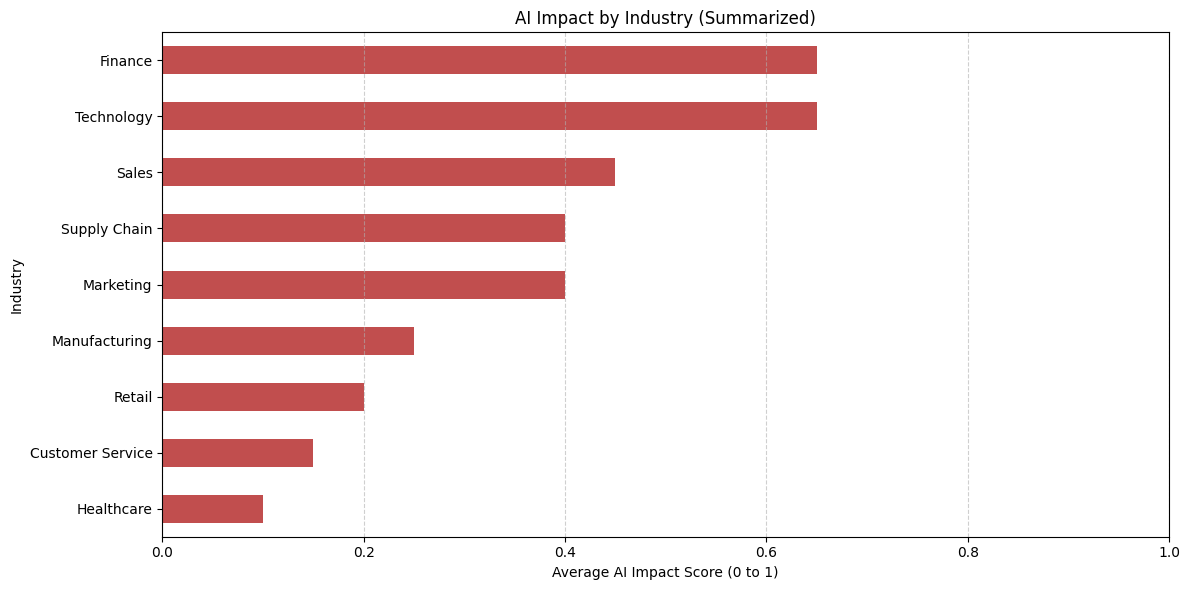

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === LOAD DATA ===
ai_risk_df = pd.read_csv("Ai_risk.csv")  # Ensure the file is in the same directory

# === CHECK FOR JOB TITLE COLUMN ===
print(ai_risk_df.columns)  # Find correct job title column
job_column = "Job_Title" if "Job_Title" in ai_risk_df.columns else ai_risk_df.columns[0]  # Change this after checking

# === CONVERT AI IMPACT FROM PERCENTAGE TO NUMERIC SCORE ===
ai_risk_df["AI_Impact_Score"] = (
    ai_risk_df["AI Impact"]
    .astype(str)
    .str.replace('%', '', regex=True)
    .astype(float) / 100  # Convert percentage to 0-1 scale
)

# === REMOVE MISSING VALUES ===
ai_risk_df = ai_risk_df.dropna(subset=["AI_Impact_Score"])

# === GROUP JOBS INTO GENERAL INDUSTRY CATEGORIES ===
industry_mapping = {
    "Software Engineer": "Technology",
    "Data Scientist": "Technology",
    "IT Support": "Technology",
    "Marketing Analyst": "Marketing",
    "Financial Analyst": "Finance",
    "Accountant": "Finance",
    "HR Manager": "Human Resources",
    "Sales Representative": "Sales",
    "Factory Worker": "Manufacturing",
    "Retail Associate": "Retail",
    "Medical Assistant": "Healthcare",
    "Nurse": "Healthcare",
    "Logistics Coordinator": "Supply Chain",
    "Warehouse Manager": "Supply Chain",
    "Customer Service Representative": "Customer Service",
    # Add more mappings as needed
}

# Apply the mapping to categorize industries
ai_risk_df["General_Industry"] = ai_risk_df[job_column].map(industry_mapping)

# Remove rows where General Industry is still NaN (not mapped)
ai_risk_df = ai_risk_df.dropna(subset=["General_Industry"])

# === GET AVERAGE AI IMPACT PER GENERAL INDUSTRY ===
avg_impact = (
    ai_risk_df.groupby("General_Industry")["AI_Impact_Score"]
    .mean()
    .sort_values(ascending=False)
)

# === PLOT THE DATA ===
plt.figure(figsize=(12, 6))
avg_impact.plot(kind="barh", color="firebrick", alpha=0.8)
plt.title("AI Impact by Industry (Summarized)")
plt.xlabel("Average AI Impact Score (0 to 1)")
plt.ylabel("Industry")
plt.xlim(0, 1)  # AI impact should be between 0 and 1
plt.gca().invert_yaxis()  # Flip order for better readability
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()

# === SAVE THE PLOT AS A PNG FILE (OPTIONAL) ===
plt.savefig("Summarized_AI_Impact_by_Industry.png", dpi=300, bbox_inches="tight")  # Saves as PNG
plt.show()


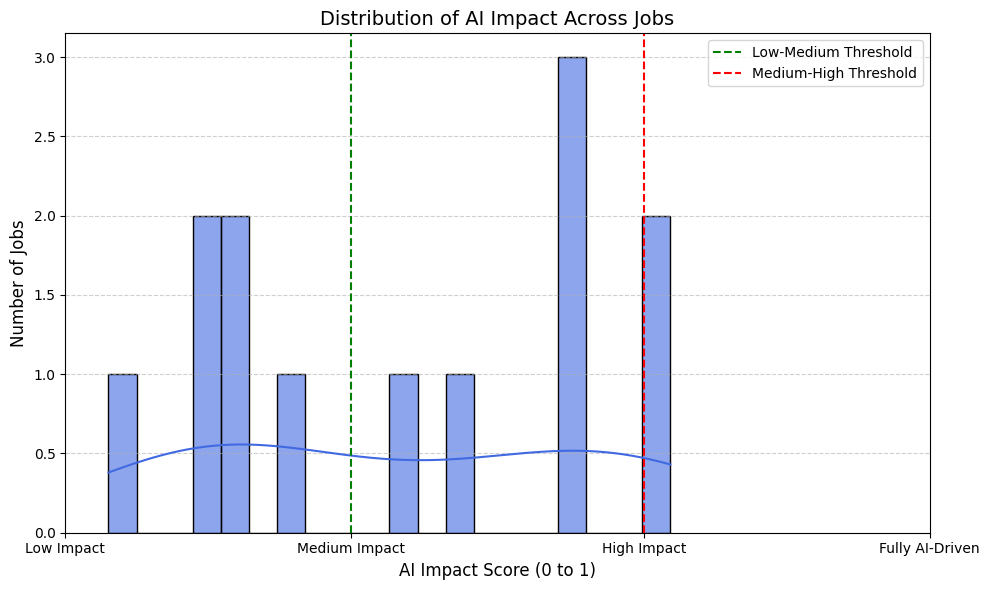

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# === FIXED AI IMPACT DISTRIBUTION HISTOGRAM ===
plt.figure(figsize=(10, 6))

# Increase bins for smoother distribution
sns.histplot(ai_risk_df["AI_Impact_Score"], bins=20, kde=True, color="royalblue", alpha=0.6)

# Add title and labels
plt.title("Distribution of AI Impact Across Jobs", fontsize=14)
plt.xlabel("AI Impact Score (0 to 1)", fontsize=12)
plt.ylabel("Number of Jobs", fontsize=12)
plt.xticks([0, 0.33, 0.67, 1], ["Low Impact", "Medium Impact", "High Impact", "Fully AI-Driven"])
plt.axvline(0.33, color="green", linestyle="--", label="Low-Medium Threshold")
plt.axvline(0.67, color="red", linestyle="--", label="Medium-High Threshold")

# Add legend for clarity
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# === LOAD DATA ===
ai_risk_df = pd.read_csv("Ai_risk.csv")
job_market_df = pd.read_csv("Cleaned_ai_job_market_insights.csv")
ai_adoption_df = pd.read_csv("Cleaned_Analysis_AIAdoption_AutomationRisk.csv")

# === CLEAN & MERGE ===
ai_risk_df.rename(columns={"Job titiles": "Job_Title", "Domain": "Industry"}, inplace=True)
merged_df = ai_risk_df.merge(job_market_df, on=["Industry", "Job_Title"], how="left")\
                      .merge(ai_adoption_df, on=["Industry", "Job_Title"], how="left")
merged_df_cleaned = merged_df.dropna(axis=1, how="all")

# === FEATURE ENGINEERING ===
merged_df_cleaned["AI_Impact_Percentage"] = merged_df_cleaned["AI models"] / merged_df_cleaned["Tasks"]
merged_df_cleaned["Industry_Risk_Level"] = merged_df_cleaned["Industry"].map({
    "Service Operations": 1, "Supply Chain": 1, "Finance": 0, "IT": -1, "Marketing": -1, "Manufacturing": 0
}).fillna(0)
le = LabelEncoder()
merged_df_cleaned["AI_Impact_Label"] = le.fit_transform(merged_df_cleaned["AI Impact"])

# === REMOVE RARE CLASSES (< 5 samples) ===
label_counts = merged_df_cleaned["AI_Impact_Label"].value_counts()
valid_labels = label_counts[label_counts >= 5].index
merged_df_cleaned = merged_df_cleaned[merged_df_cleaned["AI_Impact_Label"].isin(valid_labels)]

# === CLEAN INVALID VALUES ===
merged_df_cleaned["AI_Impact_Percentage"].replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df_cleaned["AI_Impact_Percentage"].fillna(merged_df_cleaned["AI_Impact_Percentage"].median(), inplace=True)
merged_df_cleaned["AI_Workload_Ratio"].fillna(merged_df_cleaned["AI_Workload_Ratio"].median(), inplace=True)

X = merged_df_cleaned[["Tasks", "AI models", "AI_Workload_Ratio", "AI_Impact_Percentage", "Industry_Risk_Level"]]
y = merged_df_cleaned["AI_Impact_Label"]

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.median(), inplace=True)

# === SCALE AND SPLIT ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# === MODEL TUNING ===
dt_params = {"max_depth": [5, 10, 20, None], "min_samples_split": [2, 5, 10], "min_samples_leaf": [1, 2, 4]}
rf_params = {"n_estimators": [100, 200], "max_depth": [5, 10, 20, None], "min_samples_split": [2, 5, 10]}

dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    dt_params, cv=3, scoring="accuracy", n_jobs=-1
)
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    rf_params, cv=3, scoring="accuracy", n_jobs=-1
)

dt_grid.fit(X_train, y_train)
rf_grid.fit(X_train, y_train)

# === RESULTS ===
dt_best = dt_grid.best_estimator_
rf_best = rf_grid.best_estimator_

dt_acc = accuracy_score(y_test, dt_best.predict(X_test))
rf_acc = accuracy_score(y_test, rf_best.predict(X_test))

print("=== Decision Tree ===")
print("Best Params:", dt_grid.best_params_)
print("Accuracy:", round(dt_acc * 100, 2), "%")
print("Feature Importances:", dict(zip(X.columns, dt_best.feature_importances_)))

print("\n=== Random Forest ===")
print("Best Params:", rf_grid.best_params_)
print("Accuracy:", round(rf_acc * 100, 2), "%")
print("Feature Importances:", dict(zip(X.columns, rf_best.feature_importances_)))


/tmp/ipykernel_1538/1051243245.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_cleaned["AI_Impact_Percentage"] = merged_df_cleaned["AI models"] / merged_df_cleaned["Tasks"]
/tmp/ipykernel_1538/1051243245.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_cleaned["Industry_Risk_Level"] = merged_df_cleaned["Industry"].map({
/tmp/ipykernel_1538/1051243245.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

=== Decision Tree ===
Best Params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 35.18 %
Feature Importances: {'Tasks': np.float64(0.2325627968669494), 'AI models': np.float64(0.3156546009868714), 'AI_Workload_Ratio': np.float64(0.1970169294061759), 'AI_Impact_Percentage': np.float64(0.25476567274000333), 'Industry_Risk_Level': np.float64(0.0)}

=== Random Forest ===
Best Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 40.83 %
Feature Importances: {'Tasks': np.float64(0.24648275048025112), 'AI models': np.float64(0.26687994036303464), 'AI_Workload_Ratio': np.float64(0.24644991931874966), 'AI_Impact_Percentage': np.float64(0.2401873898379645), 'Industry_Risk_Level': np.float64(0.0)}


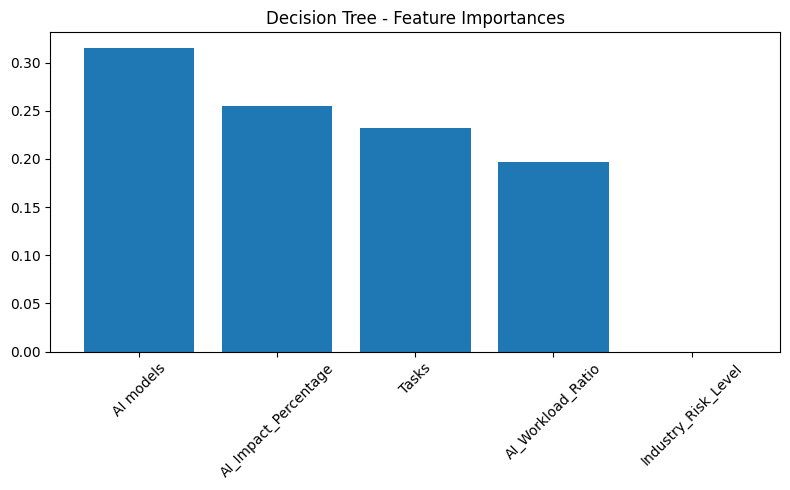

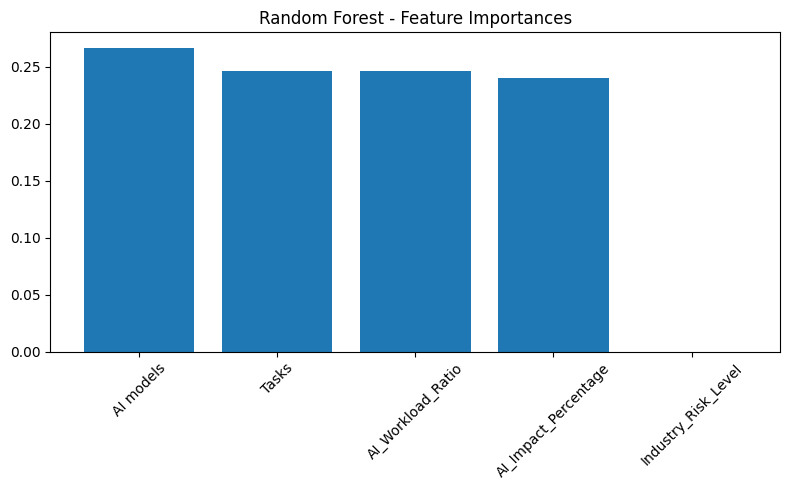

In [3]:
import matplotlib.pyplot as plt

# === FEATURE IMPORTANCE PLOTS ===
def plot_feature_importance(model, model_name, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(8, 5))
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
    plt.title(f"{model_name} - Feature Importances")
    plt.tight_layout()
    plt.show()

plot_feature_importance(dt_best, "Decision Tree", X.columns)
plot_feature_importance(rf_best, "Random Forest", X.columns)
